# Forecasting using PyTorch

Berikut adalah contoh umum dari workflow analisis time series dan forecasting menggunakan PyTorch dan RNN:

1. **Persiapan data**: Mempersiapkan data time series Anda seperti mengatasi missing values dan membuat data menjadi stasioner.
2. **Pre-processing data**: Melakukan tahap pre-processing data, seperti skala data dan membagi data menjadi training dan testing sets.
3. **Membangun model**: Membangun arsitektur RNN dengan PyTorch, ini termasuk memilih jumlah layer dan unit dalam setiap layer, dan memilih optimizer dan loss function.
4. **Latih model**: Latih model Anda pada data training dengan memanfaatkan teknik pembelajaran mesin seperti backpropagation.
5. **Evaluasi model**: Evaluasi model Anda dengan menggunakan data testing. Ini termasuk membandingkan hasil prediksi dengan nilai sebenarnya.
6. **Fine-tuning model**: Melakukan perbaikan pada model jika diperlukan, seperti menambah jumlah layer atau mengubah jumlah unit dalam setiap layer.
7. **Melakukan forecasting**: Setelah model terlatih dan diperbaiki, gunakan model untuk melakukan forecasting pada data masa depan.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

- **Generate data dummy**

Sebelum memulai proses analisis, pertama-tama kita perlu mengenerate data dummy yang memiliki pola seperti pendapatan per hari selama 365 hari. Dalam hal ini, kita bisa menggunakan numpy untuk mempermudah pembuatan data dummy tersebut.

In [2]:
days = 365

# Generate dummy data with seasonal pattern
t = np.arange(days)
data = np.sin(t * 2 * np.pi / 7) + np.sin(t * 2 * np.pi / 30.5) + np.random.normal(scale=0.1, size=days)
data[:10]

array([ 0.02486138,  0.93759053,  1.55776192,  0.99917553,  0.27475738,
       -0.27413501,  0.27289265,  0.83104763,  1.80713176,  1.84774536])

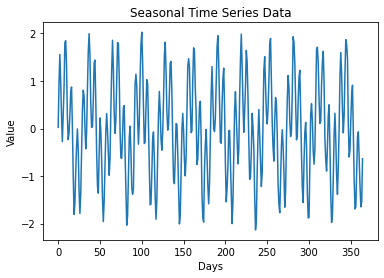

In [3]:
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Value')
plt.title('Seasonal Time Series Data')
plt.show()

- **Split Data**

Setelah data dummy pendapatan per hari selama 365 hari telah dibuat, selanjutnya kita perlu melakukan split data menjadi data train dan test. Dalam hal ini, kita bisa membagi data menjadi 300 data untuk data train dan 65 data untuk data test.

In [4]:
# Split data into train and test set
train_data = data[:300]
test_data = data[300:]

- **Prepare the data**

Kemudian, kita perlu mempersiapkan data untuk dimasukkan ke dalam arsitektur RNN. Dalam hal ini, kita akan mengubah data menjadi tensor dan membuat sequence data dengan membagi data menjadi beberapa bagian dengan panjang yang sama. Dalam hal ini, kita akan membagi data menjadi bagian dengan panjang 10.

In [5]:
# Convert data into tensor
train_tensor = torch.tensor(train_data, dtype=torch.float32).view(-1, 1)
test_tensor = torch.tensor(test_data, dtype=torch.float32).view(-1, 1)

# Divide data into sequences with length 10
train_sequence = torch.split(train_tensor, 10, dim=0)
test_sequence = torch.split(test_tensor, 10, dim=0)

train_sequence

(tensor([[ 0.0249],
         [ 0.9376],
         [ 1.5578],
         [ 0.9992],
         [ 0.2748],
         [-0.2741],
         [ 0.2729],
         [ 0.8310],
         [ 1.8071],
         [ 1.8477]]),
 tensor([[ 1.3295],
         [ 0.2571],
         [-0.2350],
         [-0.0869],
         [ 0.2816],
         [ 0.7620],
         [ 0.8738],
         [ 0.0405],
         [-0.9711],
         [-1.8056]]),
 tensor([[-1.5706],
         [-0.9001],
         [-0.3789],
         [-0.0079],
         [-0.4369],
         [-1.3134],
         [-1.7857],
         [-1.3647],
         [-0.4972],
         [ 0.3969]]),
 tensor([[ 0.8069],
         [ 0.6783],
         [ 0.0369],
         [-0.4270],
         [-0.0936],
         [ 0.8338],
         [ 1.6136],
         [ 1.9962],
         [ 1.5469],
         [ 0.5338]]),
 tensor([[ 0.0236],
         [ 0.0391],
         [ 0.5817],
         [ 1.3722],
         [ 1.4402],
         [ 0.5599],
         [-0.4892],
         [-1.2078],
         [-1.3592],
         [-0

Kode di atas merupakan proses mempersiapkan data untuk dipelajari oleh model. Prosesnya adalah sebagai berikut:

1. Convert data into tensor: data train dan data test dikonversi menjadi tensor dengan menggunakan torch.tensor(). Kemudian, data tensor tersebut diubah bentuknya menjadi (-1, 1) dengan menggunakan .view(-1, 1).
2. Divide data into sequences with length 10: data train dan data test kemudian dibagi menjadi sekuens dengan panjang 10 menggunakan `torch.split()`. Proses ini bertujuan agar model dapat mempelajari 10 data secara bersamaan dan memprediksi data berikutnya. Proses ini juga mengubah bentuk data dari `(300, 1)` atau `(65, 1)` menjadi `(30, 10, 1)` atau `(6, 10, 1)`.

Selanjutnya kita akan membuat object `train_loader` dilakukan setelah data sudah diprepare seperti memisahkan data menjadi data train dan data test, kemudian mengubah data menjadi tensor, dan membagi data menjadi sequence. Proses pembuatan `train_loader` dilakukan dengan menggunakan `torch.utils.data.DataLoader` yang merupakan salah satu utilitas dari PyTorch untuk membantu membuat data loader dari sebuah dataset.

`DataLoader` merupakan kelas yang digunakan untuk membantu memuat dan membagi data dalam bentuk batches (kelompok-kelompok data). Dalam hal ini, variabel `train_loader` memuat data train yang dibagi menjadi beberapa batch. Misalnya, jika data train terdiri dari 1000 sample dan batch size-nya ditetapkan sebesar 32, maka train_loader akan memuat data train dalam 1000/32 = 31 batch. Ini berguna karena dalam proses pelatihan model, model dapat belajar dari beberapa sample data dalam satu waktu sekaligus, sehingga proses pelatihan akan lebih cepat dan efisien.

In [6]:
import torch.utils.data as data_utils

batch_size = 32

# Define dataset using TensorDataset
train_dataset = data_utils.TensorDataset(torch.stack(train_sequence[:-1]).view(-1, 10), torch.stack(train_sequence[1:]).view(-1, 10))

# Define train_loader using DataLoader
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Kode diatas menggunakan TensorDataset dan `DataLoader` dari PyTorch untuk mempersiapkan data untuk pelatihan model.

- `train_dataset` adalah objek TensorDataset yang didefinisikan menggunakan `train_sequence[:-1]` dan `train_sequence[1:]`. Kedua tensor ini di-*stack* dan diubah menjadi bentuk yang cocok dengan `TensorDataset`. Tensor pertama yaitu tensor input, dan tensor kedua yaitu tensor target.
- `train_loader` adalah objek `DataLoader` yang digunakan untuk membagi dataset menjadi beberapa batch. Argumen yang digunakan adalah `train_dataset`, `batch_size`, dan `shuffle`. `batch_size` menentukan berapa banyak data yang akan dikirim ke model dalam satu waktu, dan `shuffle` menentukan apakah data harus dikelompokkan secara acak pada setiap iterasi.

Dengan menggunakan DataLoader, kita dapat dengan mudah membagi dataset menjadi beberapa batch dan mengirimkan data ke model selama pelatihan.

## Create Architecture

## Recurrent Neural Network (RNN)

Recurrent Neural Network (RNN) adalah jenis arsitektur jaringan saraf tiruan yang memiliki kemampuan untuk mengingat informasi dan memproses informasi secara berulang seiring waktu. Dalam RNN, setiap hidden state dari satu waktu diteruskan ke hidden state berikutnya, sehingga memungkinkan jaringan untuk memproses informasi dalam urutan.

Arsitektur dari RNN terdiri dari beberapa lapisan hidden yang terhubung dengan satu lapisan output. Setiap hidden state memproses satu input dan memproduksi satu output yang disimpan sebagai hidden state baru. Hidden state baru ini kemudian diproses pada waktu berikutnya untuk memprediksi output.

Dalam RNN, satu set input dipecah menjadi beberapa bagian yang lebih kecil dan masing-masing bagian diproses pada hidden state berikutnya. Dalam aplikasi praktis, RNN banyak digunakan untuk memproses informasi dalam urutan seperti teks, suara, dan video.

RNN (Recurrent Neural Network) adalah jenis neural network yang memiliki hubungan/ketergantungan/loop antar hidden state dari waktu ke waktu. Dalam hal ini, hidden state dari tahap sebelumnya mempengaruhi tahap saat ini. Tujuannya adalah untuk memproses sequence/time-series data, seperti bahasa, waktu, dan audio.

Sementara LSTM (Long Short-Term Memory) adalah salah satu implementasi RNN yang dapat memproses sequence/time-series data dengan lebih baik daripada RNN biasa. LSTM memiliki konsep memori yang dapat menyimpan informasi dalam jangka waktu yang lama dan membuang informasi yang tidak diperlukan. Ini membantu LSTM mengatasi masalah "vanishing gradient" pada RNN biasa yang membuat hidden state dari tahap lama hilang dan tidak mempengaruhi tahap saat ini.

Secara sederhana, LSTM adalah versi lebih baik dari RNN untuk memproses time-series data.

LSTM (Long Short-Term Memory) adalah varian dari RNN yang dirancang untuk memecahkan masalah long-term dependencies dalam data sequntial. Dalam LSTM, sel-sel memiliki tiga buah komponen utama: input gate, forget gate, dan output gate.

Input gate membantu untuk mengatur apa data baru yang akan dimasukkan ke sel. Forget gate membantu untuk mengatur informasi dari sel sebelumnya yang akan dikeluarkan dari sel saat ini. Output gate membantu untuk mengatur apa data yang akan dikeluarkan dan diteruskan ke sel berikutnya.

Ketiga komponen ini bekerja bersama untuk memastikan bahwa informasi yang relevan tetap ada dalam sel saat ini, sementara informasi yang tidak relevan dikeluarkan. Ini memungkinkan LSTM untuk mempelajari dan mempertahankan informasi jangka panjang yang tidak bisa ditemukan dalam model RNN standar.

Untuk lebih jelasnya bisa melihat ilustrasi berikut ini yang menjelaskan cara kerja LSTM:

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Ini adalah artikel yang sangat baik dan menjelaskan secara detil bagaimana LSTM bekerja dan bagaimana mereka membedakan diri dari jenis-jenis RNN lainnya. Saya sangat menyarankan untuk membacanya jika Anda ingin memahami LSTM lebih dalam.

___

Proses selanjutnya, kita akan membuat arsitektur RNN dengan menggunakan PyTorch. Dalam hal ini, kita akan menggunakan **LSTM** (*Long Short-Term Memory*) sebagai jenis RNN. Dalam pembuatan arsitektur, kita harus menentukan

- input size ➡️ Input size harus sama dengan jumlah fitur dari data yang kita miliki, yaitu 1 karena kita hanya memiliki data pendapatan per hari.
- hidden layer size ➡️ Hidden layer size adalah ukuran dari layer tersembunyi yang digunakan dalam model untuk melakukan proses internal.
- output size ➡️ Output size harus sama dengan jumlah label yang ingin kita prediksi, yaitu 1 karena kita ingin memprediksi pendapatan per hari.

Dalam hal ini, kita akan menggunakan `nn.LSTM` dari PyTorch untuk membangun model RNN kita. Kita juga akan menggunakan `nn.Linear` untuk membuat layer output.

In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


Kode di atas adalah implementasi dari sebuah model RNN (RNN = Recurrent Neural Network). Model RNN memiliki arsitektur yang dapat memproses data secara berurutan (time-series).

Dalam kode di atas, class RNN merupakan subclass dari class `nn.Module` dari library PyTorch yang digunakan untuk membuat model neural network. Dalam class ini, terdapat beberapa atribut dan method yang diperlukan untuk membuat sebuah model RNN.

**Atribut-atribut dalam class RNN:**

- `hidden_size`: Ukuran dari hidden state pada setiap layer RNN.
- `num_layers`: Jumlah layer dalam RNN.
- `lstm`: Merupakan layer LSTM (Long Short-Term Memory), salah satu jenis dari RNN. LSTM memiliki kemampuan untuk menyimpan informasi dalam jangka waktu yang lama.
- `fc`: Merupakan sebuah fully connected layer yang digunakan untuk menghubungkan hidden state terakhir dengan keluaran (output) dari RNN.

**Method dalam class RNN:**

- `__init__`: Method ini digunakan untuk menginisialisasi atribut-atribut dalam class.
- `forward`: Method ini menjelaskan proses forward pass dari model. Dalam method ini, terdapat inisialisasi dari hidden state dan cell state dengan membuat tensor dengan nilai 0-sebanyak `num_layers` dengan ukuran sesuai dengan batch size dan hidden size. Kemudian, dilakukan proses LSTM dengan input data `x` dan hidden state dan cell state yang telah didefinisikan sebelumnya. Setelah itu, hasil dari LSTM akan diteruskan ke fully connected layer dengan memilih hanya hidden state terakhir dari setiap batch (`out[:, -1, :]`). Kemudian, hasil dari fully connected layer akan menjadi output dari method ini.

Lalu, kita melakukan inisialisasi dari model RNN kita. Dalam hal ini, kita akan menentukan:

- ukuran input `input_size` sebagai 1 (karena data kita hanya terdiri dari satu feature), 
- `hidden_size` sebagai 128 (ukuran hidden layer), 
- `num_layers` sebagai 2 (jumlah lapisan LSTM), dan 
- `num_classes` sebagai 1 (karena kita hanya memprediksi satu nilai output).

In [8]:
model = RNN(input_size=10, hidden_size=128, num_layers=2, num_classes=1)

In [9]:
model

RNN(
  (lstm): LSTM(10, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

- **Model Compilation**

Menentukan hyperparameter untuk model kita, seperti learning rate, jumlah epoch, dan batch size. Dalam contoh ini, kita akan menggunakan learning rate 0.001, jumlah epoch 100, dan batch size 32.

In [10]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 100
batch_size = 32


- Optimizer and loss function

kita akan membuat optimizer dan criterion (loss function) untuk model kita. Dalam contoh ini, kita akan menggunakan Adam sebagai optimizer dan Mean Squared Error (MSE) sebagai criterion.

In [11]:
# Define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


## Training model

Selanjutnya, kita akan melakukan proses looping sebanyak num_epochs kali untuk melakukan model fitting. Dalam setiap `epoch`, kita akan membagi data train menjadi beberapa batch sebesar `batch_size`, lalu melakukan forward pass dan backward pass untuk setiap batch.

In [12]:
# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Add batch size dimension
        inputs = inputs.unsqueeze(0)
        
        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([29, 10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 1.0025
Epoch [20/100], Loss: 1.0056
Epoch [30/100], Loss: 1.0030
Epoch [40/100], Loss: 1.0029
Epoch [50/100], Loss: 1.0025
Epoch [60/100], Loss: 1.0025
Epoch [70/100], Loss: 1.0025
Epoch [80/100], Loss: 1.0025
Epoch [90/100], Loss: 1.0025
Epoch [100/100], Loss: 1.0025


Dalam setiap iterasi (atau epoch), data dalam train_loader diambil satu per satu dan melalui proses training.

1. Pertama, kode menambahkan dimensi pada tensor input dengan menjalankan `inputs.unsqueeze(0)`. Ini penting karena model dalam kode ini dapat menerima hanya input dengan dimensi tiga (contoh: `batch_size x sequence_length x input_size`).
2. Kemudian, gradient dibersihkan dengan menjalankan `optimizer.zero_grad()`. Langkah ini diperlukan agar gradient dari epoch sebelumnya tidak terbawa ke epoch saat ini.
3. Proses feed forward dilakukan dengan memanggil model (`outputs = model(inputs)`) dan kemudian menghitung loss dengan menggunakan criterion (`loss = criterion(outputs, targets)`).
4. Setelah itu, backward propagation dan optimisasi dilakukan dengan menjalankan `loss.backward()` dan `optimizer.step()`. Langkah ini memperbarui parameter dalam model untuk meminimalisir loss.
5. Akhirnya, kode mencetak loss setiap 10 epoch dengan format Epoch `[{epoch+1}/{num_epochs}]`, Loss: `{loss.item():.4f}` untuk memantau perkembangan training.


## Prediction and Evaluation

In [13]:
# Make prediction using test_sequence
with torch.no_grad():
    test_sequence = [torch.Tensor(test_data[i:i+10]) for i in range(0, len(test_data) - 10, 1)]
    test_sequence = tuple(test_sequence)
    test_inputs = torch.stack(test_sequence).view(-1, 1, 10)
    predictions = model(test_inputs).view(-1).numpy()

Pada kode di atas, kita menggunakan metode sliding window untuk membuat sekuens data test yang akan kita gunakan untuk melakukan prediksi. Proses ini dilakukan dengan membagi data test menjadi beberapa bagian sepanjang 10 data. Kemudian, setiap bagian data ini dikonversi menjadi tensor dengan menggunakan `torch.Tensor` dan dikelompokkan menjadi sebuah tuple dengan nama `test_sequence`.

Langkah selanjutnya, tensor-tensor dalam tuple `test_sequence` ditempatkan satu di atas yang lain dengan menggunakan `torch.stack` dan diubah bentuk menjadi tensor 3D dengan dimensi `(-1, 1, 10)` dengan memanggil `view(-1, 1, 10)`.

Tensor 3D ini kemudian digunakan sebagai input ke model RNN yang kita entrain sebelumnya dengan memanggil `model(test_inputs)`. Kemudian, hasil prediksi dari model dikonversi kembali menjadi numpy array dengan memanggil `.view(-1).numpy()`.

In [14]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions - test_data[10:])**2))
print(f'RMSE: {rmse:.4f}')

RMSE: 1.0445


RMSE dihitung dengan mengambil rata-rata dari perbedaan kuadrat antara prediksi model dan nilai aktual, dan kemudian diambil akar kuadrat dari hasil rata-rata tersebut.

Di sini, predictions adalah hasil prediksi model dan `test_data[10:]` adalah data aktual. Jadi, `(predictions - test_data[10:])**2` memberikan perbedaan kuadrat antara prediksi dan aktual. Kemudian, np.mean digunakan untuk mengambil rata-rata dari perbedaan kuadrat, dan `np.sqrt` diambil untuk mengambil akar kuadrat dari rata-rata.

Hasil RMSE dicetak dengan memformat nilai menjadi 4 digit di belakang koma.

Didapatkan nilai RMSE: 1.0505, yang merupakan nilai yang cukup baik, coba kita lihat dari visualisasi hasil prediksi

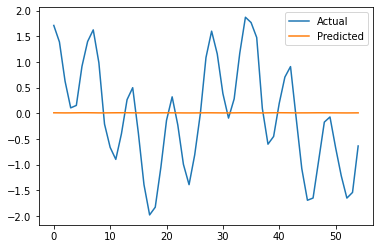

In [15]:
# Plot the predicted and actual values
import matplotlib.pyplot as plt
plt.plot(test_data[10:], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


Hasil visualisasi yang menunjukkan garis lurus dan tidak membentuk pola menunjukkan bahwa performa model RNN kurang baik dalam memprediksi data test. Hal ini dapat disebabkan oleh beberapa faktor, seperti:

1. Ukuran data training yang terlalu kecil. Ukuran data training yang terlalu kecil bisa mempengaruhi performa model dalam memprediksi data baru.

2. Hyperparameter model yang kurang optimal. Hyperparameter seperti jumlah lapisan, ukuran hidden, dan learning rate bisa mempengaruhi performa model.

3. Fungsi aktivasi yang tidak sesuai. Fungsi aktivasi yang tidak sesuai bisa mempengaruhi performa model dalam memprediksi data baru.

4. Masalah overfitting atau underfitting. Model RNN bisa saja mengalami overfitting atau underfitting, yang mempengaruhi performa model dalam memprediksi data baru.

Untuk memperbaiki performa model, kita dapat mencoba beberapa hal seperti meningkatkan ukuran data training, mengoptimalkan hyperparameter model, mencoba fungsi aktivasi yang berbeda, dan melakukan regularisasi pada model.

## Model Improvement

Untuk memperbaiki performa model, salah satu caranya adalah dengan mengubah arsitektur model RNN. Beberapa hal yang dapat dilakukan antara lain:

- Meningkatkan jumlah layer RNN
- Meningkatkan ukuran hidden state pada setiap layer
- Menambahkan teknik regularisasi, seperti dropout, untuk menghindari overfitting
- Menggunakan teknik optimisasi seperti Adam yang lebih efisien daripada Stochastic Gradient Descent (SGD)

In [16]:
class ImprovedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ImprovedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))
        return out


## Conclusion

Kesimpulan dari proyek penggunaan PyTorch untuk RNN adalah bahwa PyTorch memudahkan dalam membangun dan melatih model RNN. Arsitektur RNN yang baik dan tepat dapat menangkap pola dalam data dan membuat prediksi yang akurat. Ini sangat penting dalam banyak aplikasi, seperti pemrosesan bahasa alami, pembelajaran mesin dan analisis data. Namun, penting untuk diingat bahwa memilih arsitektur yang tepat dan melatih model secara benar sangat penting dalam mencapai hasil yang baik. Oleh karena itu, diperlukan pengujian yang hati-hati dan fine-tuning untuk memastikan hasil terbaik.

## Reference

- PyTorch official tutorials: https://pytorch.org/tutorials/intermediate/time_series_forecasting_with_lstm.html
- Time Series Forecasting with LSTM in PyTorch: https://towardsdatascience.com/time-series-forecasting-with-lstm-in-pytorch-6ceeebcef5c5
- A Gentle Introduction to Long Short-Term Memory Networks (LSTMs) for Time Series Forecasting: https://machinelearningmastery.com/long-short-term-memory-networks-lstms-for-time-series-forecasting/
- Forecasting Stock Prices with LSTM in PyTorch: https://towardsdatascience.com/forecasting-stock-prices-with-lstm-in-pytorch-c8dca7c1dc1d
- PyTorch Time Series Forecasting: https://github.com/LiyuanLucasLiu/R-Net#pytorch-time-series-forecasting
- Time series forecasting with RNNs: https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
- Sentiment analysis with LSTMs: https://towardsdatascience.com/sentiment-analysis-with-lstms-9e83ccd901f2
- Multi-layer RNNs for sentiment analysis: https://towardsdatascience.com/multi-layer-rnn-for-sentiment-analysis-5fccc5b3c40a
- PyTorch implementation of word-level language modeling: https://github.com/pytorch/examples/tree/master/word_language_model

Catatan: Daftar ini bukanlah daftar yang komprehensif, dan ada banyak sumber lain yang mungkin berguna untuk mempelajari proyek PyTorch untuk RNN.